In [1]:
import gc
import os
import sys
import itertools
import pickle
from glob import glob
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
DEVICE = 'cuda'

In [4]:
import sys
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            # loss_partial, initial_coef, method='Powell')
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [5]:
# sys.path.append('../scripts/')
# from get_optR3 import compute_spearmanr, get_opt_y_pred

import os
import pickle
import sys
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm


class histogramBasedCoefInitializer:
    def __init__(self):
        self.bins = None

    def fit(self, labels):
        self.bins = pd.Series(
            labels).value_counts().sort_index().cumsum().values
        return self

    def predict(self, preds):
        preds = sorted(preds)
        res_threshs = []
        if self.bins is None:
            raise Exception('plz fit at first.')
        for _bin in self.bins[:-1]:
            res_threshs.append((preds[_bin - 1] + preds[_bin]) / 2)
        return res_threshs


class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels


def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        if len(np.unique(col_pred)) == 1:
            if col_pred[0] == np.max(col_trues):
                col_pred[np.argmin(
                    col_pred)] = np.min(col_trues)
            else:
                col_pred[np.argmax(
                    col_pred)] = np.max(col_trues)
        rhos.append(
            spearmanr(
                col_trues,
                col_pred
                #                  + np.random.normal(
                #                     0,
                #                     1e-7,
                #                     col_pred.shape[0])
            ).correlation)
    return rhos


def get_best_ckpt(ckpts):
    ckpt_dicts = []
    for ckpt in ckpts:
        ckpt_dict = {}
        ckpt_dict['ckpt'] = ckpt
        splitted_ckpt = ckpt.split('/')[-1].split('_')
        ckpt_dict['val_metric'] = float(splitted_ckpt[5])
        ckpt_dicts.append(ckpt_dict)
    ckpt_df = pd.DataFrame(ckpt_dicts)
    return ckpt_df.sort_values('val_metric', ascending=False).ckpt.iloc[0]


def get_snapshot_info_df(base_dir):
    res_dicts = []
    for fold in tqdm(list(range(5))):
        fold_ckpts = glob(f'{base_dir}/{fold}/*.pth')
        for ckpt in fold_ckpts:
            res_dict = {}
            splitted_ckpt = ckpt.split('/')[-1].split('_')
            res_dict['ckpt_filename'] = ckpt
            res_dict['fold'] = int(splitted_ckpt[1])
            res_dict['epoch'] = int(splitted_ckpt[3])
            res_dict['val_loss'] = float(splitted_ckpt[4])
            res_dict['val_metric'] = float(splitted_ckpt[5])
            res_dicts.append(res_dict)
    res_df = pd.DataFrame(res_dicts)
    res_df['rank'] = res_df.groupby(['fold']).val_metric.rank()
    return res_df


def get_opt_y_pred(y_true, y_pred, num_labels):
    optRs = []
    opt_y_preds = []

    # for i in tqdm(list(range(21))):
    for i in range(num_labels):
        optR = OptimizedRounder()
        labels = np.sort(np.unique(y_true[:, i]))
        optR.set_labels(labels)
        initer = histogramBasedCoefInitializer().fit(y_true[:, i])
        opt_thresh = initer.predict(y_pred[:, i])
        optR.fit(y_pred[:, i], y_true[:, i], opt_thresh)
        # opt_threshs.append(optR.coefficients())
        # opt_threshs[i] = optR.coefficients()
        optRs.append(optR)
        opt_y_preds.append((optR.predict(y_pred[:, i], optR.coefficients())))

    opt_y_preds = np.asarray(opt_y_preds).T
    return optRs, opt_y_preds


def opt(BASE_PATH, num_labels=30, snapshot_num=2):
    snapshot_df = get_snapshot_info_df(BASE_PATH)

    snapshot_dicts = {}
    state_dict_dicts = {}
    for fold in tqdm(list(range(5))):
        snapshot_dict = {}
        state_dict_dict = {}
        for i, row in snapshot_df.query(f'fold == {fold}').sort_values(
                'rank', ascending=False).reset_index(drop=True).iterrows():
            if i >= snapshot_num:
                continue
            ckpt = torch.load(row['ckpt_filename'])
            state_dict_dict[i] = ckpt['model_state_dict']
            if i == 0:
                qa_ids = ckpt['val_qa_ids']
                qa_ids_argsort = np.argsort(qa_ids)
                snapshot_dict['y_trues'] = [
                    ckpt['val_y_trues'][qa_ids_argsort]]
                snapshot_dict['y_preds'] = [
                    ckpt['val_y_preds'][qa_ids_argsort]]
            else:
                qa_ids = ckpt['val_qa_ids']
                qa_ids_argsort = np.argsort(qa_ids)
                snapshot_dict['y_trues'].append(
                    ckpt['val_y_trues'][qa_ids_argsort])
                snapshot_dict['y_preds'].append(
                    ckpt['val_y_preds'][qa_ids_argsort])
        snapshot_dicts[fold] = snapshot_dict
        state_dict_dicts[fold] = state_dict_dict

    y_preds = np.concatenate(
        [np.average(snapshot_dicts[fold]['y_preds'][:snapshot_num], axis=0)
         for fold in range(5)])
    y_trues = np.concatenate(
        [snapshot_dicts[fold]['y_trues'][0]
         for fold in range(5)])

    reses = []
    optRs = []

    for i in tqdm(list(range(num_labels))):
        y_pred = y_preds[:, i]
        y_true = y_trues[:, i]

        y_pred_argmax = np.argmax(y_pred)
        y_pred_argmin = np.argmin(y_pred)

        optR = OptimizedRounder()
        labels = np.sort(np.unique(y_true))
        optR.set_labels(labels)
        initer = histogramBasedCoefInitializer().fit(y_true)
        initial_coef = initer.predict(y_pred)
        optR.fit(y_pred, y_true, initial_coef=initial_coef)
        optRs.append(optR)
        res = optR.predict(y_pred, optR.coefficients())

        if len(np.unique(res)) == 1:
            if np.unique(res) == res[y_pred_argmax]:
                res[y_pred_argmin] = np.min(y_true)
            else:
                res[y_pred_argmax] = np.max(y_true)

        reses.append(res)
    reses = np.asarray(reses).T

    with open(f'{BASE_PATH}/optRs.pkl', 'wb') as fout:
        pickle.dump(optRs, fout)
    with open(f'{BASE_PATH}/snapshot_dicts.pkl', 'wb') as fout:
        pickle.dump(snapshot_dicts, fout)
    if not os.path.exists(f'{BASE_PATH}/state_dicts'):
        os.mkdir(f'{BASE_PATH}/state_dicts')
    for fold in range(5):
        for rank in range(snapshot_num):
            with open(f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl', 'wb') as fout:
                pickle.dump(state_dict_dicts[fold][rank], fout)
    # with open(f'{BASE_PATH}/state_dict_dicts.pkl', 'wb') as fout:
    #     pickle.dump(state_dict_dicts, fout)

    original_score = compute_spearmanr(y_trues, y_preds)
    print(f'original_score: {original_score}')
    print(f'original_score: {np.mean(original_score)}')

    res_score = compute_spearmanr(y_trues, reses)
    print(f'res_score: {res_score}')
    print(f'res_score_mean: {np.mean(res_score)}')

    return res_score

In [6]:
class histogramBasedCoefInitializer:
    def __init__(self):
        self.bins = None

    def fit(self, labels):
        self.bins = pd.Series(labels).value_counts().sort_index().cumsum().values
        return self

    def predict(self, preds):
        preds = sorted(preds)
        res_threshs = []
        if self.bins is None:
            raise Exception('plz fit at first.')
        for _bin in self.bins[:-1]:
            res_threshs.append((preds[_bin - 1] + preds[_bin]) / 2)
        return res_threshs

In [7]:
def blend_and_evaluate(y_trues, y_preds_list, eval_func, weights=None):
    if weights:
        y_preds = np.average(y_preds_list, axis=0, weights=weights)
    else:
        y_preds = np.average(y_preds_list, axis=0)
    eval_scores = eval_func(y_trues, y_preds)
    optRs, opt_y_preds = get_opt_y_pred(y_trues, y_preds, num_labels=30)
    opt_eval_scores = eval_func(y_trues, opt_y_preds)
    print(f'original_score: {np.mean(eval_scores)}')
    print(f'opt_score: {np.mean(opt_eval_scores)}')
    return eval_scores, opt_eval_scores, optRs

In [ ]:
CKPT_DIR = '../mnt/checkpoints'

with open(f'{CKPT_DIR}/e078/snapshot_dicts.pkl', 'rb') as fin:
    bert_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e079/snapshot_dicts.pkl', 'rb') as fin:
    bert_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e080/snapshot_dicts.pkl', 'rb') as fin:
    roberta_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e081/snapshot_dicts.pkl', 'rb') as fin:
    roberta_answer_dict = pickle.load(fin)
    
# with open(f'{CKPT_DIR}/e072/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_question_dict = pickle.load(fin)
# with open(f'{CKPT_DIR}/e073/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e082/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e083/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_answer_dict = pickle.load(fin)

## train の各 col 分布をみる

In [18]:
trn_df = pd.read_csv('../mnt/inputs/origin/train.csv')
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')

raw_preds_df = pd.read_csv('../mnt/inputs/pseudos/top2_e078_e079_e080_e081_e082_e083/raw_pseudo_tst_df.csv')
opt_preds_df = pd.read_csv('../mnt/inputs/pseudos/top2_e078_e079_e080_e081_e082_e083/opt_pseudo_tst_df.csv')

In [14]:
label_cols = trn_df.columns[11:].tolist()

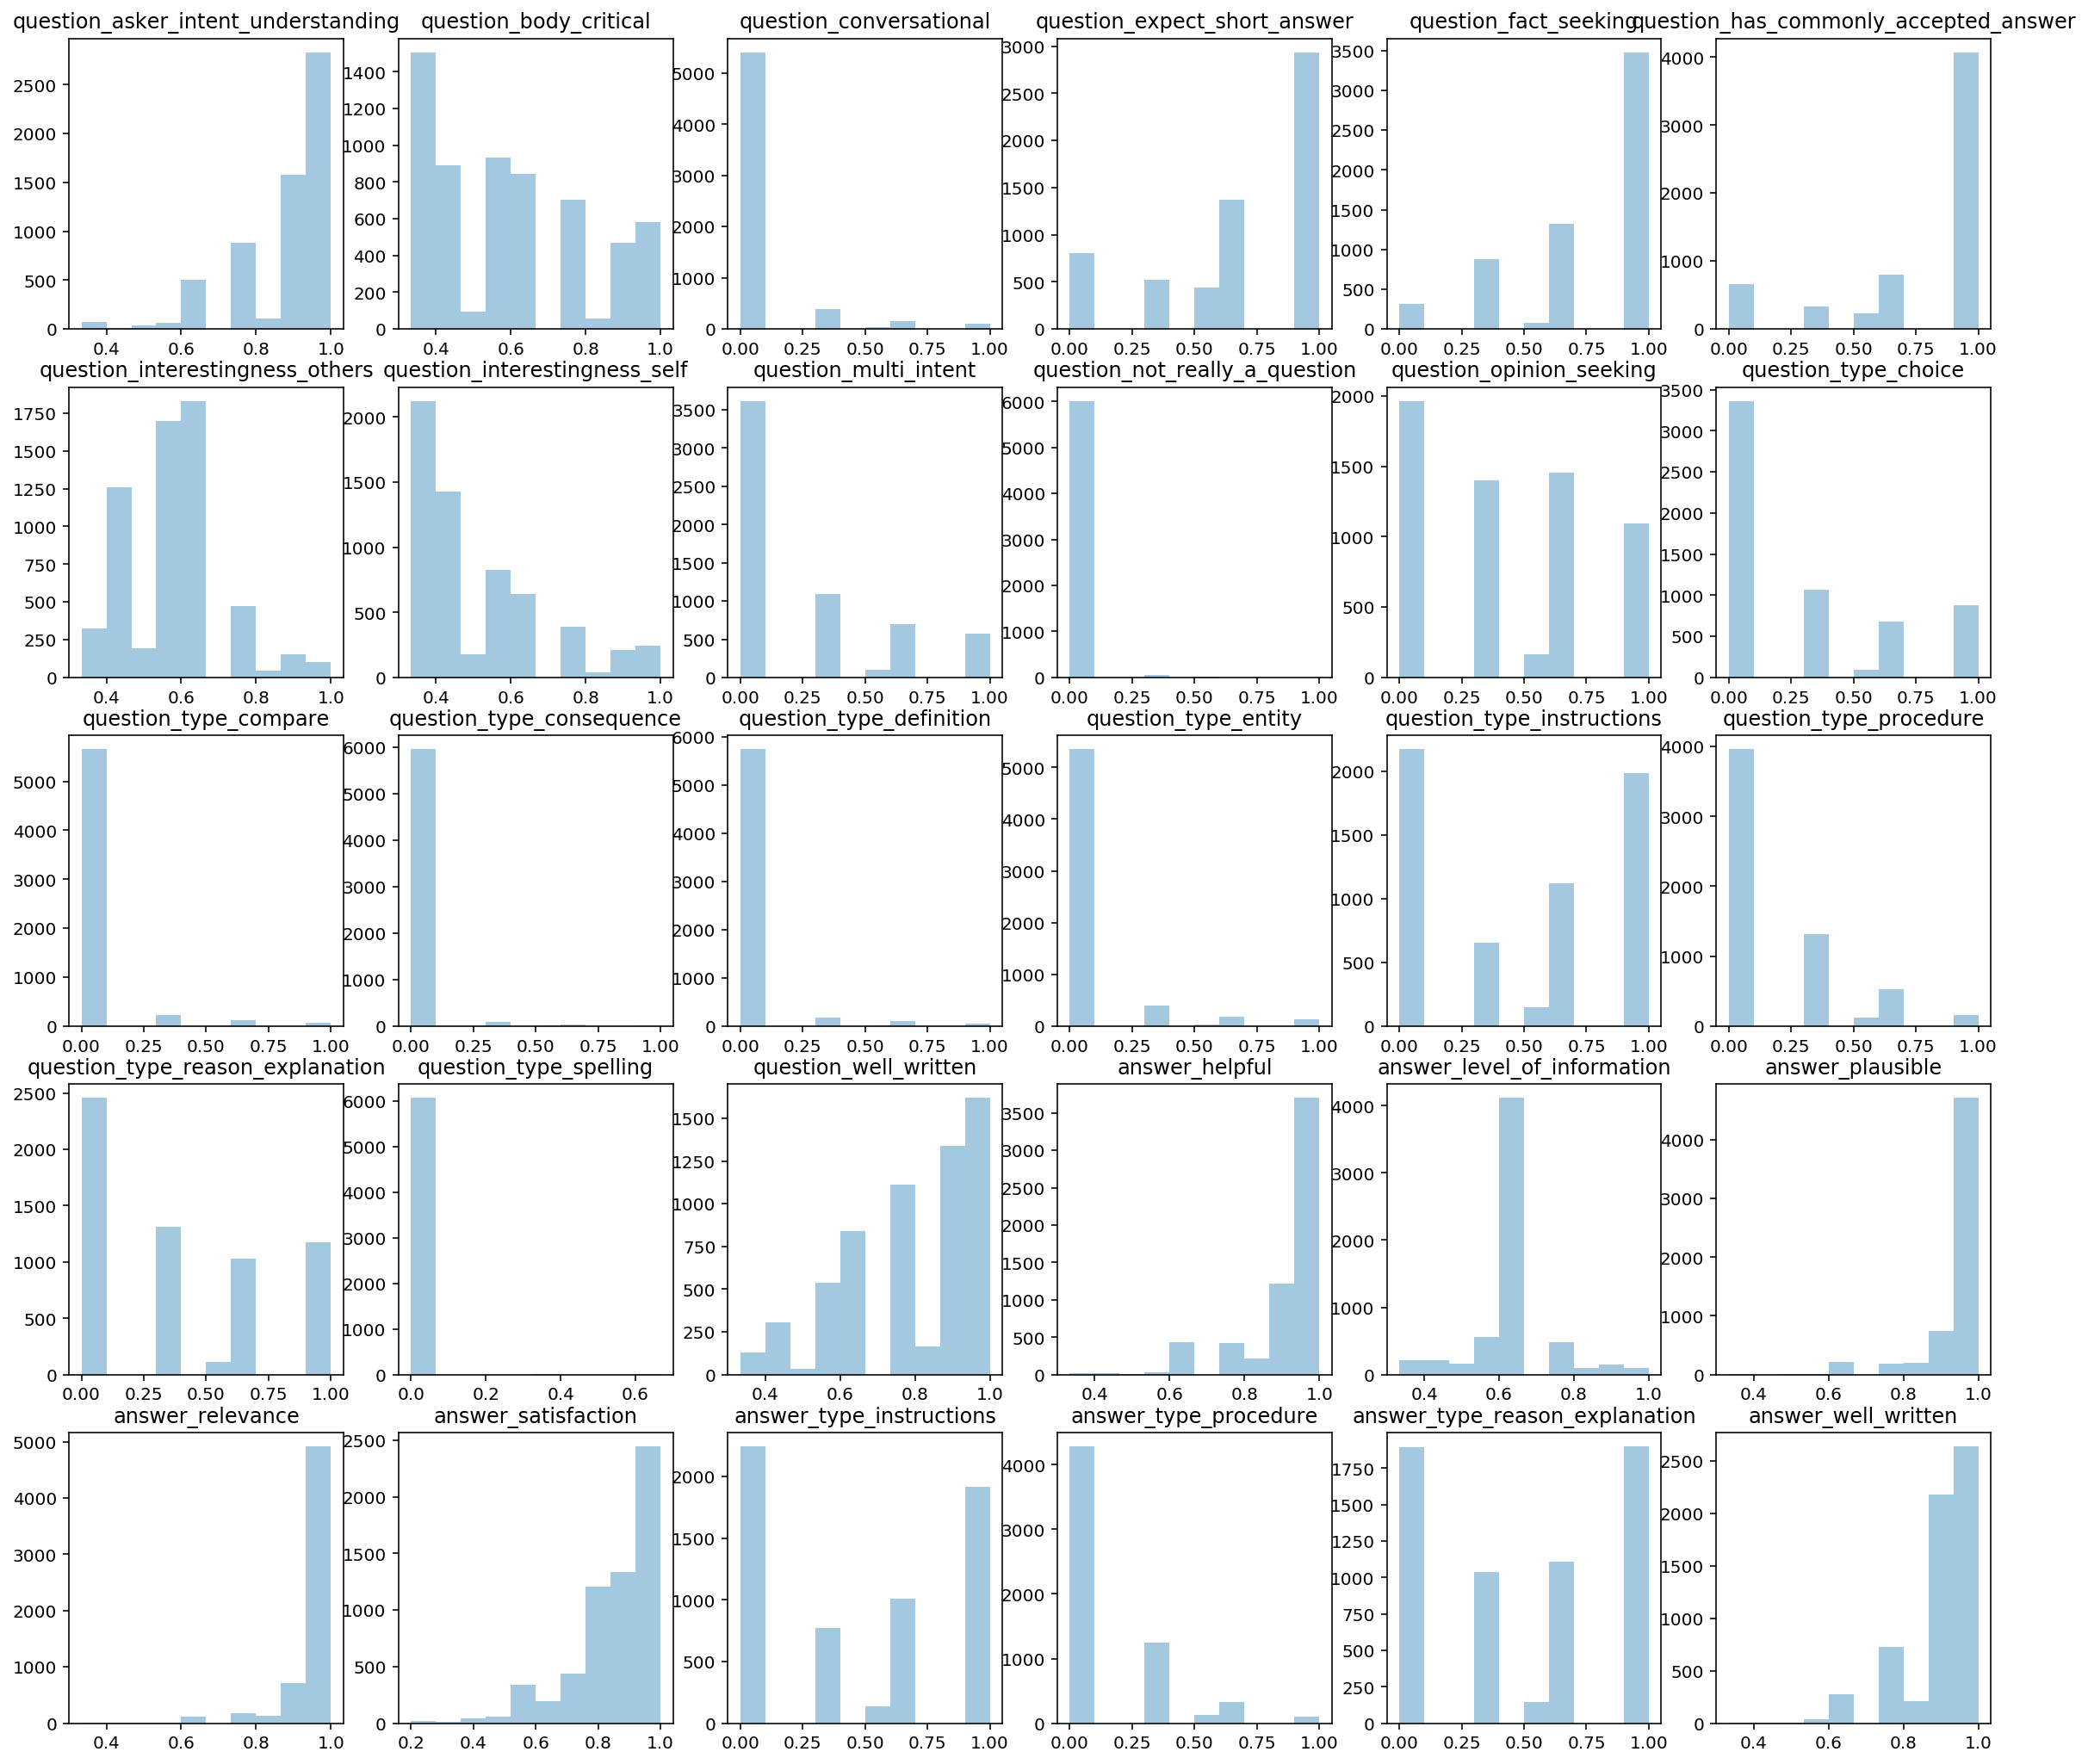

In [15]:
fig, axs = plt.subplots(5, 6, figsize=(20, 18))

for col, ax in zip(label_cols, axs.flatten()):
    ax.hist(trn_df[col], alpha=0.4)
    ax.set_title(f'{col}')
plt.show()

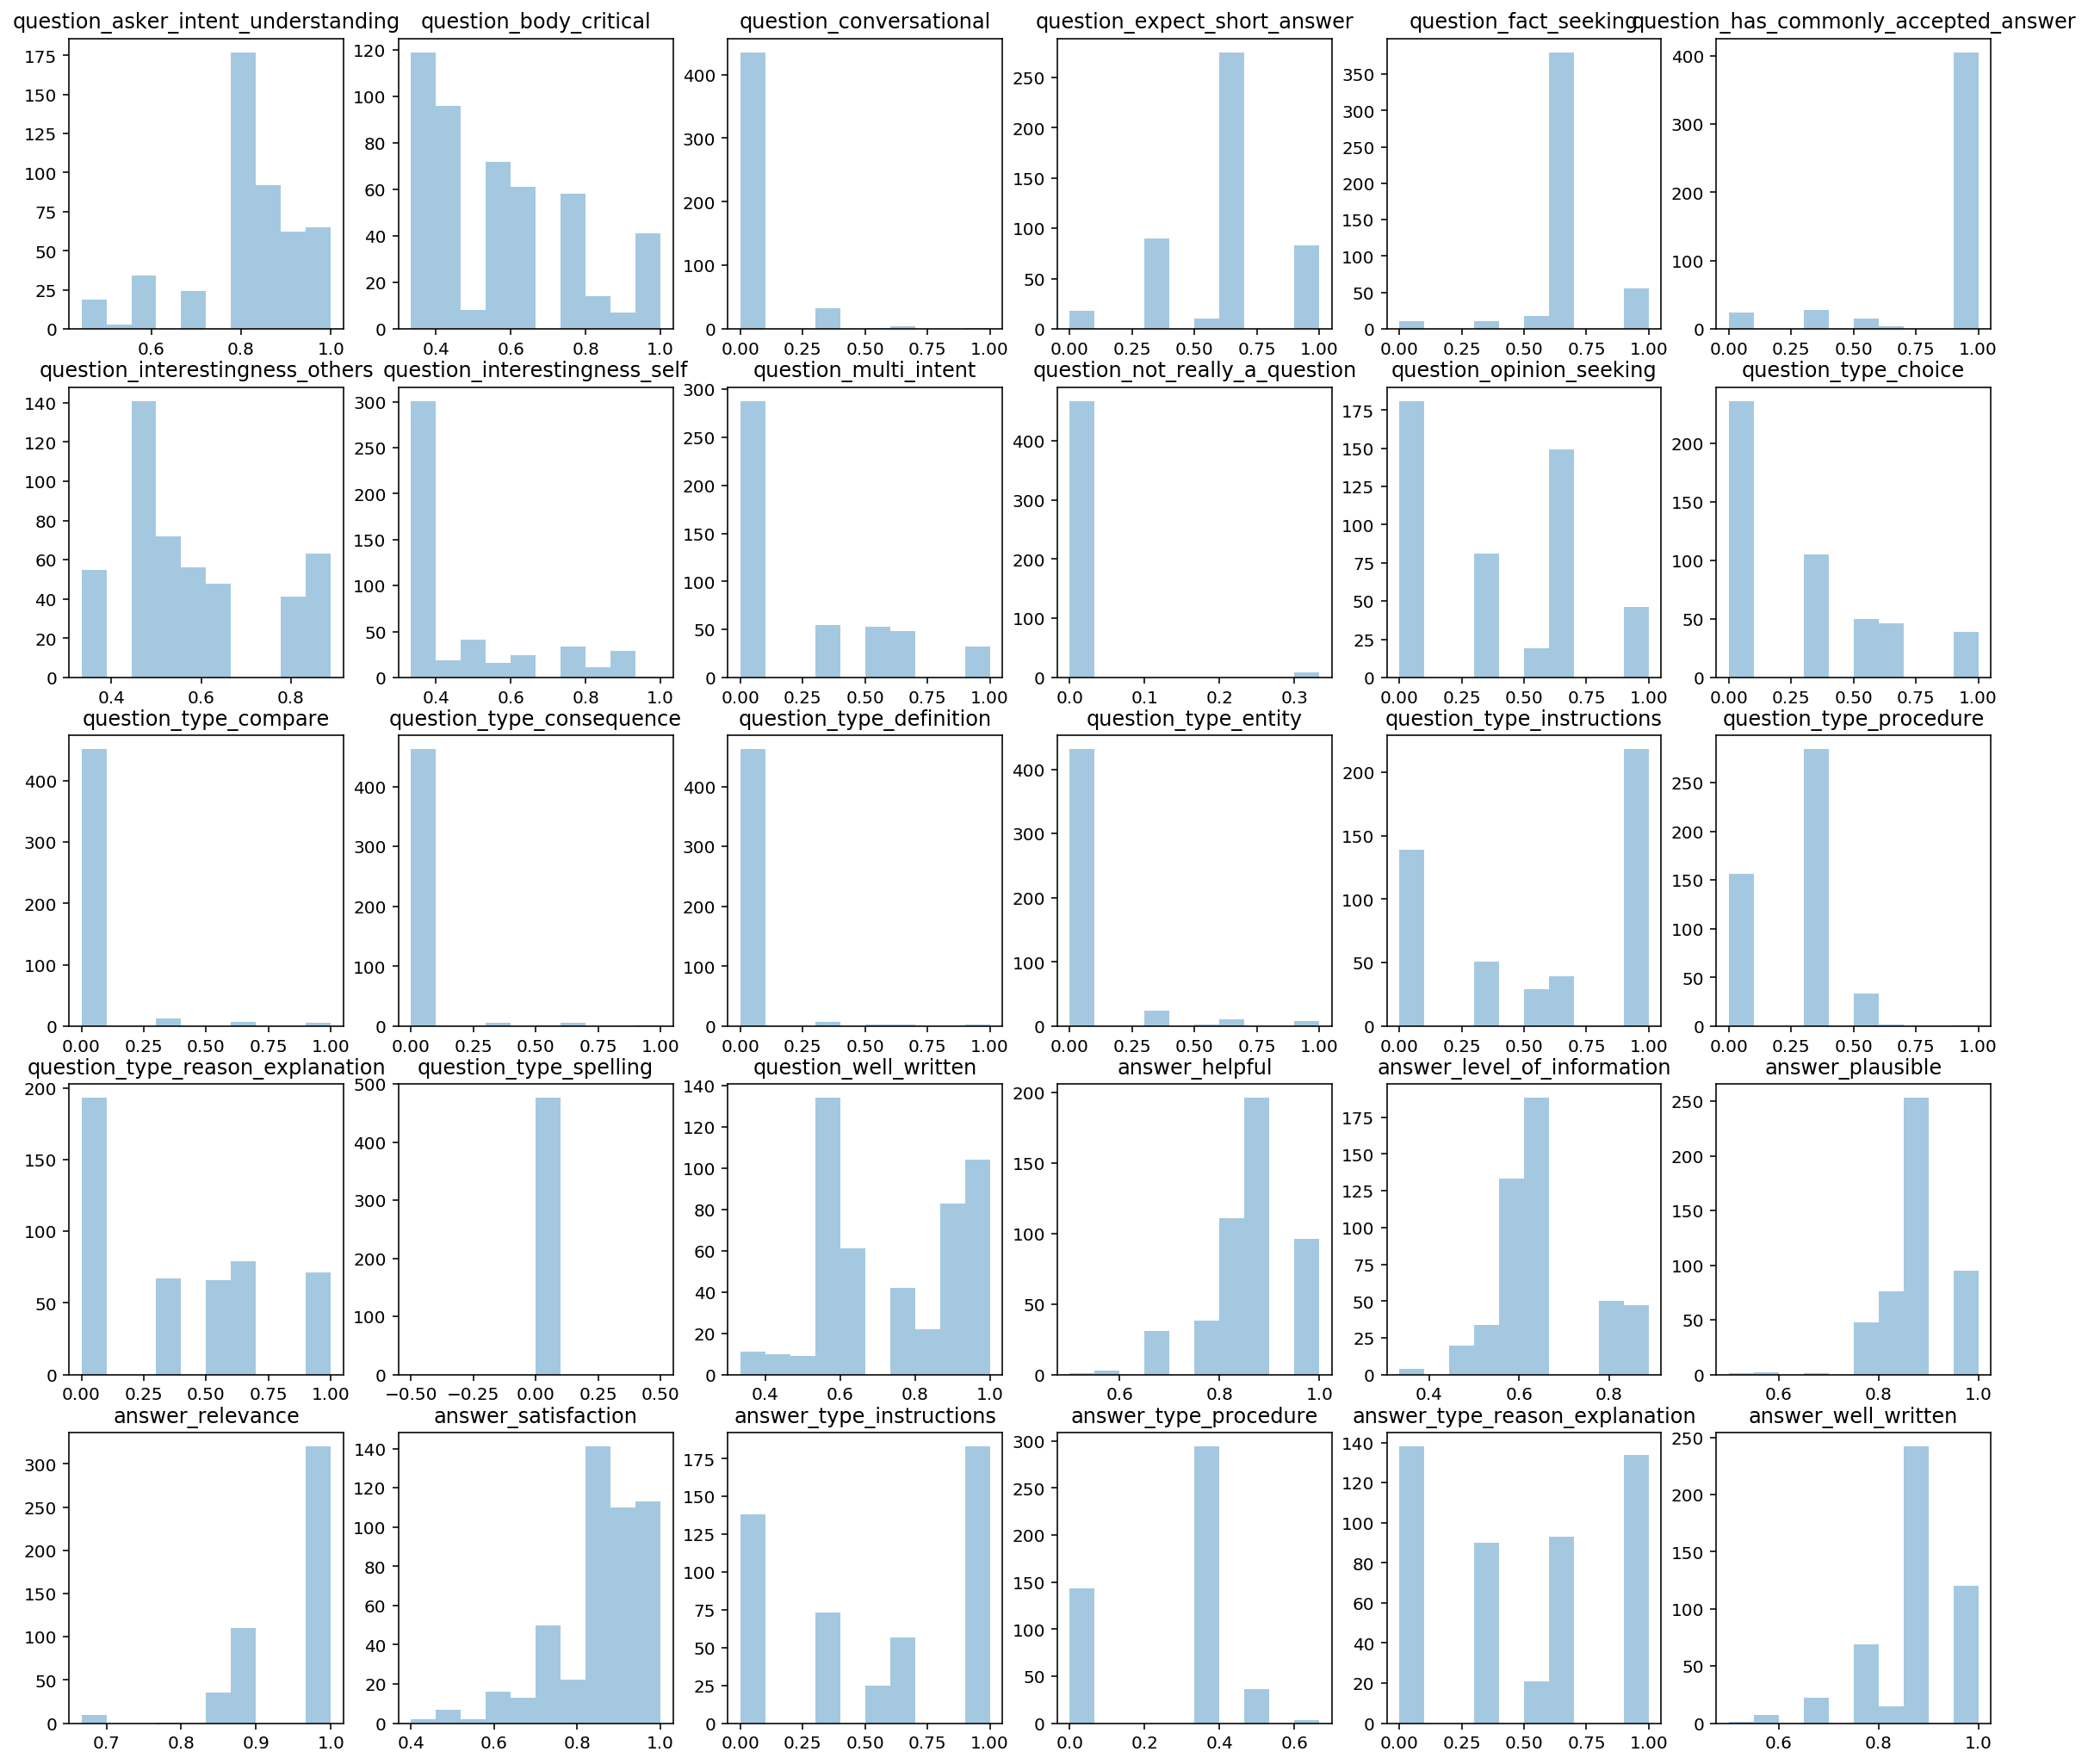

In [19]:
fig, axs = plt.subplots(5, 6, figsize=(20, 18))

for col, ax in zip(label_cols, axs.flatten()):
    ax.hist(opt_preds_df[col], alpha=0.4)
    ax.set_title(f'{col}')
plt.show()